# NLP. Sentiment LSTM

In this nobebook I will preprocess film reviews data and train a model based on LSTM to classify the reviews into 2 classes (positive and negative).

In [1]:
!pip install --upgrade torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 133.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.

## Data preparation

### Download Dataset

I will use the IMDB Reviews dataset for mobile electronics.

In [2]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np

imdb_train = tfds.load('imdb_reviews/plain_text', split='train', shuffle_files=True)
imdb_train = tfds.as_dataframe(imdb_train)
print(imdb_train.head())

imdb_train_x = np.array([s.decode('utf-8') for s in imdb_train['text'].tolist()])
imdb_train_y = imdb_train['label'].to_numpy()
print(f"imdb_reviews(split='train'): x={len(imdb_train_x)}, y={len(imdb_train_y)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RRULOE_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RRULOE_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RRULOE_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
   label                                               text
0      0  b"This was an absolutely terrible movie. Don't...
1      0  b'I have been known to fall asleep during film...
2      0  b'Mann photographs the Alberta Rocky Mountains...
3      1  b'This is the kind of film for a snowy Sunday ...
4      1  b'As others have mentioned, all the women that...
imdb_reviews(split='train'): x=25000, y=25000


### Create Vocabulary

#### Normalizing data

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup


nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_punctuation(text):
    punct = r"[\d!\"#\$%&\'\(\)\*\+,-.\/:;<=>\?@\[\\\]\^_`{\|}~]"
    text = re.sub(punct, " ", text)
    return text

def remove_stopwords(text):
    text = " ".join([word for word in text.split(" ") if word not in stop_words])
    return text

def remove_space_symbols(text):
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    return text

def cleanup(text):
    text = text.lower()

    text = remove_html_tags(text)  # Should be called before removing punktuation, as the tags then won't be recognised by the library
    text = remove_space_symbols(text)  # Should be called before removing punktuation, as if we have such symbols as '\n', we need to preserve '\'
    text = remove_punctuation(text)
    text = remove_space_symbols(text)  # One more time, as we've replaced punctuation symbols with spaces
    text = remove_stopwords(text)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
united_train_text_corpus = ' '.join(imdb_train_x)
cleand_text_corpus = cleanup(united_train_text_corpus)

#### Tokenization

In [5]:
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

def tokenize(text):
    words = word_tokenize(text)
    return sorted(words)

words = tokenize(cleand_text_corpus)
print(f"{len(words)} words in vocabulary ({len(set(words))} unique)")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


2991139 words in vocabulary (74838 unique)


In [6]:
# Removeing rare words (frequency = 1)
from collections import Counter

frequency = Counter(words)
words = [w for w in words if frequency[w] > 1]

print(f"{len(words)} words in updated vocabulary ({len(set(words))} unique)")

2962625 words in updated vocabulary (46324 unique)


In [7]:
vocab = sorted(list(set(words)))
vocab.append('<UNK>')  # Replace all words in reviews which are not in vocab with <UNK> token
print(len(vocab))

46325


### Mapping words to ints


In [8]:
def vocabulary_to_integer(vocab):
    """
    Maps each vocab word to an integer.
    """
    vocab_to_int = dict()
    vocab_to_int['<PAD>'] = 0

    i = 1
    for word in vocab:
      vocab_to_int[word] = i
      i += 1

    return vocab_to_int

vocab_to_int = vocabulary_to_integer(vocab)
print(len(vocab_to_int))

46326


In [9]:
# Replacing all words in reviews with their indexes
imdb_train_x_num = []
for review in imdb_train_x:
    review = cleanup(review)

    encoded_review = []
    for word in review.split(" "):
      if word in vocab_to_int:
        encoded_review.append(vocab_to_int[word])
      else:
        encoded_review.append(vocab_to_int['<UNK>'])

    imdb_train_x_num.append(encoded_review)

In [10]:
from statistics import median

review_lens = Counter([len(x) for x in imdb_train_x_num])
print(f"Zero-length reviews: {review_lens[0]}")
print(f"Maximum review length: {max(review_lens)}")
print(f"Median review length: {median(review_lens)}")  # To understand which seq_length is better

Zero-length reviews: 0
Maximum review length: 1416
Median review length: 293


As we can see, there are no empty reviews, so we don't need to delete anything.

### Data padding

We will stick to left padding, i.e. we will all '<PAD>' to the left of reviews.

In [11]:
def pad_documents(reviews_ints, seq_length):
    padded_reviews = []

    for review in reviews_ints:
      if len(review) >= seq_length:
        padded_reviews.append(review[:seq_length])
      else:
        pad_cnt = seq_length - len(review)
        padded_review = [0] * pad_cnt + review
        padded_reviews.append(padded_review)

    return np.array(padded_reviews)

In [12]:
# As we have seen, meadian size is close to 300. So we will better take a bit more than that
seq_length = 400
padded_reviews_numbers = pad_documents(imdb_train_x_num, seq_length=seq_length)

### Dataloaders

In [13]:
from sklearn.model_selection import train_test_split

train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

def train_test_val_split(features):
    val_test_x, train_x = train_test_split(features, test_size=train_frac, shuffle=False)
    val_x, test_x = train_test_split(val_test_x, test_size=test_frac / (val_frac+test_frac), shuffle=False)
    return train_x, val_x, test_x

def train_test_val_labels(encoded_labels):
    val_test_y, train_y = train_test_split(encoded_labels, test_size=train_frac, shuffle=False)
    val_y, test_y = train_test_split(val_test_y, test_size=test_frac / (val_frac+test_frac), shuffle=False)
    return train_y, val_y, test_y

train_x, val_x, test_x = train_test_val_split(padded_reviews_numbers)
train_y, val_y, test_y = train_test_val_labels(imdb_train_y)

print("\t\t\tFeature Shapes:")
print(f"Train set: \t\t{train_x.shape}",
      f"\nValidation set: \t{val_x.shape}",
      f"\nTest set: \t\t{test_x.shape}")

			Feature Shapes:
Train set: 		(20000, 400) 
Validation set: 	(2500, 400) 
Test set: 		(2500, 400)


In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, drop_last=True)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


## Model

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class SentimentLSTM(nn.Module):
    """
    The LSTM model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.4):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        """
        Perform a forward pass of our model on some input.

        x: (batch_size, seq_length)
        """
        # x.shape should be (batch_size, seq_length)
        embeds = self.embedding(x)
        # embeds.shape is (batch_size, seq_length, embedding_dim)

        # embeds.shape should be (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embeds)
        # lstm_out.shape is (batch_size, seq_length, hidden_dim)

        # Here we should take only the last hidden state of LSTM
        lstm_last_output = lstm_out[:, -1, :]
        # lstm_last_output.shape is (batch_size, hidden_dim)

        dropout_out = self.dropout(lstm_last_output)
        # dropout_out.shape is the same as input shape, i.e. (batch_size, hidden_dim)

        # dropout_out.shape should be (*, hidden_dim)
        out = self.fc(dropout_out)
        # fc_out.shape is (*, output_size), where * is the same as in input

        return out

In [17]:
vocab_size = len(vocab_to_int)
output_size = 1  # For binary classification it is enough to predict only probability of first class
embedding_dim = seq_length
hidden_dim = 256
n_layers = 2

### Train

#### Loss function

**Can Cross Entropy Loss be used instead of BCELoss?**

Answer: Both yes and no. They can not be mutually replaced because of the implementation of PyTorch: CEL accepts logits whereas BCEL takes probabilities (i.e. the result of applying Softmax to the logits). But with no connection to PyTorch, CEL for 2 classes is exactly BCEL.

**Is `NLLLoss()` and last layer as `LogSoftmax()` is same as using `CrossEntropyLoss()` with a Softmax final layer?**

Let $X=(x_1, \dots, x_n)$ be a selection of observations from an unknown distribution $P\in\{P_{\theta}|\theta \in \Theta\}$ - a dominating family w.r.t. measure $\mu$.

We will call $f_{\theta}(X)=\rho_{\theta}(X)$ likelihood function of $X$, where $\rho_{\theta}(X)$ is its density w.r.t. measure $\mu$.

Let's assume that all $x_i$ are i.i.d. Then $f_{\theta}(X)=\prod\limits_{i=1}^n\rho_{\theta}(x_i)$. In our task of binary classification, $\rho_{\theta}(x_i)=\hat{y}_i^{y_i}\cdot(1-\hat{y}_i)^{1-y_i}$, where $y_i \in \{0,1\}$ - true class labels, $\hat{y}_i$ - predicted class labels.

With this in mind, one can write negative log-likelihook loss function as follows:
$$NLLL(y, \hat{s})=-\frac{1}{n}\sum\limits_{i=1}^n\bigg(y_i\log \hat{s}_i + (1-y_i)\log (1-\hat{s}_i)\bigg)$$ where $y_i \in \{0,1\}$ - true class labels, and $\hat{s}_i$ - logarithm of predicted probablities (i.e. outputs of **LogSoftmax**).

Cross entropy loss (or binary cross entropy loss in our case):
$$BCEL(y,s^*)=-\frac{1}{n}\sum\limits_{i=1}^n\bigg(y_i\log s^*_i+(1-y_i)\log (1 - s^*_i)\bigg)$$ where $y_i\in\{0,1\}$ - true class label, $s^*_i$ - class probabilities (i.e. outputs of **Softmax**).

Additionally, in our classification head we're using Sigmoid instead of Softmax. This is valid only for binary classification (i.e. when the input of these two layers consists of two logits $o_1$ and $o_2$), since $\textbf{Softmax}(o_1) = \frac{\exp(o_1)}{\exp(o_1)+\exp(o_2)}=\frac{1}{\exp(o_2-o_1)}=\textbf{Sigmoid}(o_2-o_1)$. This holds, as $o_1 - o_2$ is a linear transformation of $o_1$ and $o_2$.

In [19]:
from tqdm import tqdm

model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 5
clip = 5  # gradient clipping

model.to(device)

train_losses = []
val_losses = []
for e in range(epochs):
    # Training loop
    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Train epoch {e+1}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(inputs)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
      for inputs, labels in tqdm(valid_loader, desc=f"Val epoch {e+1}"):
          inputs, labels = inputs.to(device), labels.to(device)

          output = model(inputs)

          loss = criterion(output.squeeze(), labels.float())
          val_loss += loss.item()

      avg_val_loss = val_loss / len(valid_loader)
      val_losses.append(avg_val_loss)

      print(f"Epoch {e+1}/{epochs}: Train loss: {avg_train_loss:.6f}\t| Val loss: {avg_val_loss:.6f}")

SentimentLSTM(
  (embedding): Embedding(46326, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Val epoch 1: 100%|██████████| 39/39 [00:01<00:00, 35.79it/s]


Epoch 1/5: Train loss: 0.560734	| Val loss: 0.493525


Val epoch 2: 100%|██████████| 39/39 [00:01<00:00, 34.69it/s]


Epoch 2/5: Train loss: 0.438479	| Val loss: 0.465525


Val epoch 3: 100%|██████████| 39/39 [00:01<00:00, 33.27it/s]


Epoch 3/5: Train loss: 0.371677	| Val loss: 0.411239


Val epoch 4: 100%|██████████| 39/39 [00:01<00:00, 33.88it/s]


Epoch 4/5: Train loss: 0.318795	| Val loss: 0.344728


Val epoch 5: 100%|██████████| 39/39 [00:01<00:00, 33.93it/s]

Epoch 5/5: Train loss: 0.262634	| Val loss: 0.343842


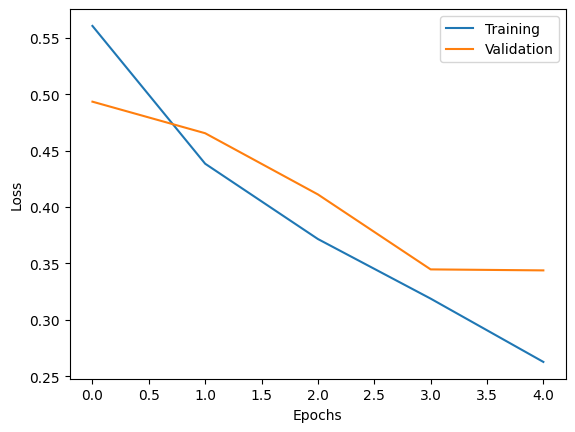

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(range(len(train_losses)), train_losses, label='Training')
plt.plot(range(len(val_losses)), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Test


In [21]:
correct_preds = 0
total_preds = 0

# Test loop
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        output = model(inputs)

        probs = torch.sigmoid(output.squeeze())
        preds = torch.round(probs)
        correct_preds += (preds == labels).sum().item()
        total_preds += batch_size

print(f"Accuracy: {correct_preds/total_preds*100:.2f}%")

Accuracy: 84.01%
